## Regression Outline
We have a set of manually categorized FERC plants with which to test the sklearn Classifier that we're making. We'll also use them to test the regression analysis here. What does this dataset look like, how was it created?
* Pull FERC Plants table.
* Using a variety of search methods, to ensure that we get a wide variety of plants, identify sets of records in the FERC Form 1 Plants table that are comparable inter-year records.


For regressions, both OLS and sklearn approaches are explored.  Plant generation is normalized by using capacity factor.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np

import scipy
import pandas as pd
import statsmodels.api as sm
import sklearn
from sklearn import linear_model
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from pudl import init, analysis, settings, output
import pudl.extract.ferc1
import pudl.transform.ferc1
import pudl.constants as pc
import pudl.output.pudltabl
import pudl.analysis.analysis
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

In [3]:
# For some reason these things don't stick if they're in the same cell as the
# %matplotlib inline call above, but if they're separate, they work fine.
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

In [4]:
pudl_out = pudl.output.pudltabl.PudlTabl()
ferc1_fuel = pudl_out.fuel_ferc1()
ferc1_steam = pudl_out.plants_steam_ferc1()

In [5]:
def ferc1_aggregate_by_fuel_type(df, fuels = ['gas', 'oil', 'coal']):
    ''' 
    Aggregate FERC 1 data by fuel type and plant per year.
    
    Inputs: 
    df is cleaned FERC 1 fuel table
    fuels is list of fuels of interest to aggregate
    
    Returns dataframe of aggregated fuel consumed and fuel costs'''
    
    fuel_df = df[df['fuel_type_code_pudl'].isin(fuels)]
    
    # We have two different ways of assessing the total cost of fuel given cost
    # per unit delivered and cost per mmbtu. They *should* be the same, but we
    # know they aren't always. Calculate both so we can compare both.
    fuel_df['fuel_consumed_total_mmbtu'] = \
        fuel_df['fuel_qty_burned'] * fuel_df['fuel_mmbtu_per_unit'] # same as total heat content
    fuel_df['fuel_consumed_total_cost_mmbtu'] = \
        fuel_df['fuel_cost_per_mmbtu'] * fuel_df['fuel_consumed_total_mmbtu']
    fuel_df['fuel_consumed_total_cost_unit'] = \
        fuel_df['fuel_cost_per_unit_burned'] * fuel_df['fuel_qty_burned']


    # Group by fuel as well, so we get individual fuel totals.
    cols_to_gb = ['plant_id_ferc1', 'report_year', 'fuel_type_code_pudl']
    cols=['fuel_consumed_total_mmbtu',
                                 'fuel_consumed_total_cost_mmbtu',
                                 'fuel_consumed_total_cost_unit']

    fuel_df = fuel_df.groupby(cols_to_gb)[cols].sum()
    fuel_df = fuel_df.reset_index()
    
    # Group by plant, so we get total fuel use/cost.
    cols_to_gb = ['plant_id_ferc1', 'report_year']
    cols=['fuel_consumed_total_mmbtu',
                                 'fuel_consumed_total_cost_mmbtu',
                                 'fuel_consumed_total_cost_unit'] 


    fuel_df_plant = fuel_df.groupby(cols_to_gb)[cols].sum()
    fuel_df_plant = fuel_df_plant.reset_index()
    
    return fuel_df_plant

In [6]:
fuel_df_plant = ferc1_aggregate_by_fuel_type(ferc1_fuel)

/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.p

In [7]:
# diff = fuel_df_plant.fuel_consumed_total_cost_mmbtu - fuel_df_plant.fuel_consumed_total_cost_unit
# Max difference in costs is on the order of 1e+9; median is 4e-1; 
# Could use this calculation comparison to eliminate, or further investigate, outliers.

In [8]:
out_df = pd.merge(fuel_df_plant, ferc1_steam, on=['plant_id_ferc1', 'report_year'])
out_df["heat_rate"] = (out_df.fuel_consumed_total_mmbtu / out_df.net_generation_mwh)
out_df['capacity_factor'] = (out_df['net_generation_mwh']/ (out_df['capacity_mw']*8760))

first_cols = [
    'report_year',
    'utility_id_ferc1',
    'plant_id_ferc1',
    'plant_name'
]

out_df = pudl.helpers.organize_cols(out_df, first_cols)

In [9]:
# Check to see if the 'tot_prdctn_expns' is equivalent to the non-fuel costs by summing non-fuel values
out_df["all_costs"] = (out_df.opex_allowances+out_df.opex_boiler+
                                  out_df.opex_coolants+
                         out_df.opex_electric+out_df.opex_engineering+
                                  out_df.opex_fuel+out_df.opex_misc_power+
                                  out_df.opex_misc_steam+
                        out_df.opex_operations+out_df.opex_plants+
                                  out_df.opex_rents+
                        out_df.opex_steam+out_df.opex_steam_other+
                                  out_df.opex_structures+
                        out_df.opex_transfer)

In [10]:
# Check to see if for all records the 'tot_prdctn_expns' approximately equals the sum from 'all_costs'
out_df['result'] = out_df['all_costs'].ge(out_df['opex_production_total']) | np.isclose(out_df['all_costs'], out_df['opex_production_total'], rtol=1e+1)

In [11]:
out_df.result.describe() # For all records, the costs are within $10. Confirms 'tot_prdctn_expsn' is all non-fuel costs

count     10552
unique        1
top        True
freq      10552
Name: result, dtype: object

In [12]:
# No need to retain these - have confirmed that 'opex_production_total' is sum of all other costs
out_df.drop(columns=['result','all_costs'], inplace=True)

In [13]:
# We can get non-fuel by subtracting opex_fuel
out_df['non_fuel_costs'] = (out_df.opex_production_total - out_df.opex_fuel)

In [14]:
out_df.installation_year = pd.to_numeric(out_df.installation_year, errors='coerce')
out_df.construction_year = pd.to_numeric(out_df.construction_year, errors='coerce')

In [15]:
# What types of fuel are included in the training data set?
out_df.plant_type.unique()

array(['steam', 'combustion_turbine', None, 'internal_combustion',
       'nuclear', 'combined_cycle', 'photovoltaic'], dtype=object)

In [16]:
out_df_s = out_df[(out_df['plant_type'] == 'steam')]
out_df_ct = out_df[(out_df['plant_type'] == 'combustion_turbine')] 
out_df_cc = out_df[(out_df['plant_type'] == 'combined_cycle')] 
out_df_ic = out_df[(out_df['plant_type'] == 'internal_combustion')]
out_df_n = out_df[(out_df['plant_type'] == 'nuclear')] 
out_df_pv = out_df[(out_df['plant_type'] == 'photovoltaic')] 

In [17]:
# combined cycle separate from combusion turbine?  For now just steam
# do both construction year and installation year for each plant type
# steam, combustion, and combined cycle - are these reasonable categorizations? are there only 6 CC plants? 
# then would need to lump those two into 'gas'
# could also use fuel table to ID primary fuel type for a plant - 90% coal vs 90% gas and partition them that way
# within gas partition between implied heat rate to differentiate CC and CT, maybe
# just trying to find natural groupings of plants that we can expect to have 
# for now just steam plants, and install vs. constr year. look at capacity; 
# if feeling curious look at heat rate associated with plant based on fuel table info to infer technology type 
# (Ultra Super Critical will have lower HR than pulverized coal 80 yr old plant)
# four discrete groups would be amazing
# Craig is a good test case
# routinely assignign different slices of plant to different plant ids if there are different owners, 
# but that would be good to know...
# 

In [18]:
steam = out_df_s.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 1007 'plants'
ct = out_df_ct.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 584 'plants'
cc = out_df_cc.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 188 'plants'
ic = out_df_ic.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 147 'plants'
nuc = out_df_n.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 5 'plants'
pv = out_df_pv.sort_values('installation_year').drop_duplicates(subset=['plant_id_ferc1'], keep='last') # 3 'plants'


/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


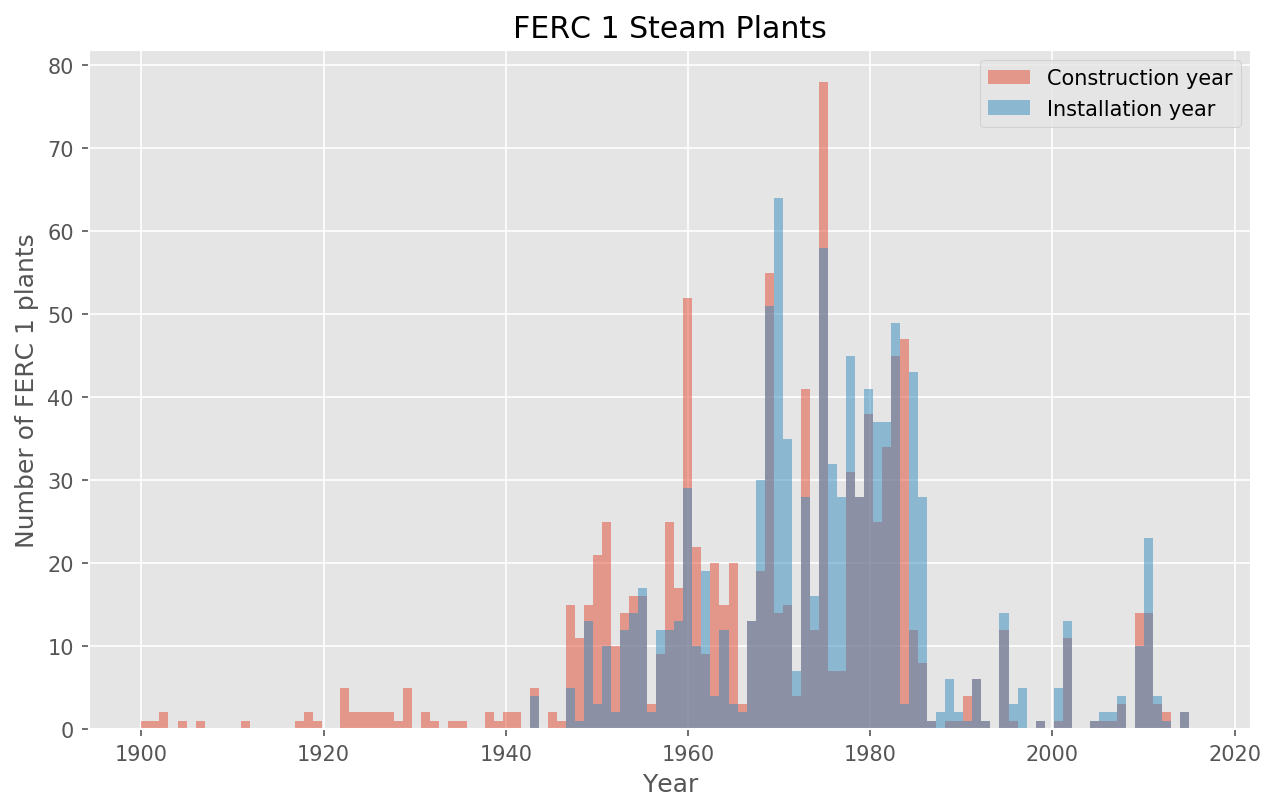

In [19]:
fig = plt.figure()

plt.xlabel('Year')
plt.ylabel('Number of FERC 1 plants')
plt.title('FERC 1 Steam Plants')

mpl.pyplot.hist(steam.construction_year, bins = 117, range = [1900,2016], alpha=0.5, label='Construction year')
mpl.pyplot.hist(steam.installation_year, bins = 117, range = [1900,2016], alpha=0.5, label='Installation year')
mpl.pyplot.legend(loc='upper right');

/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


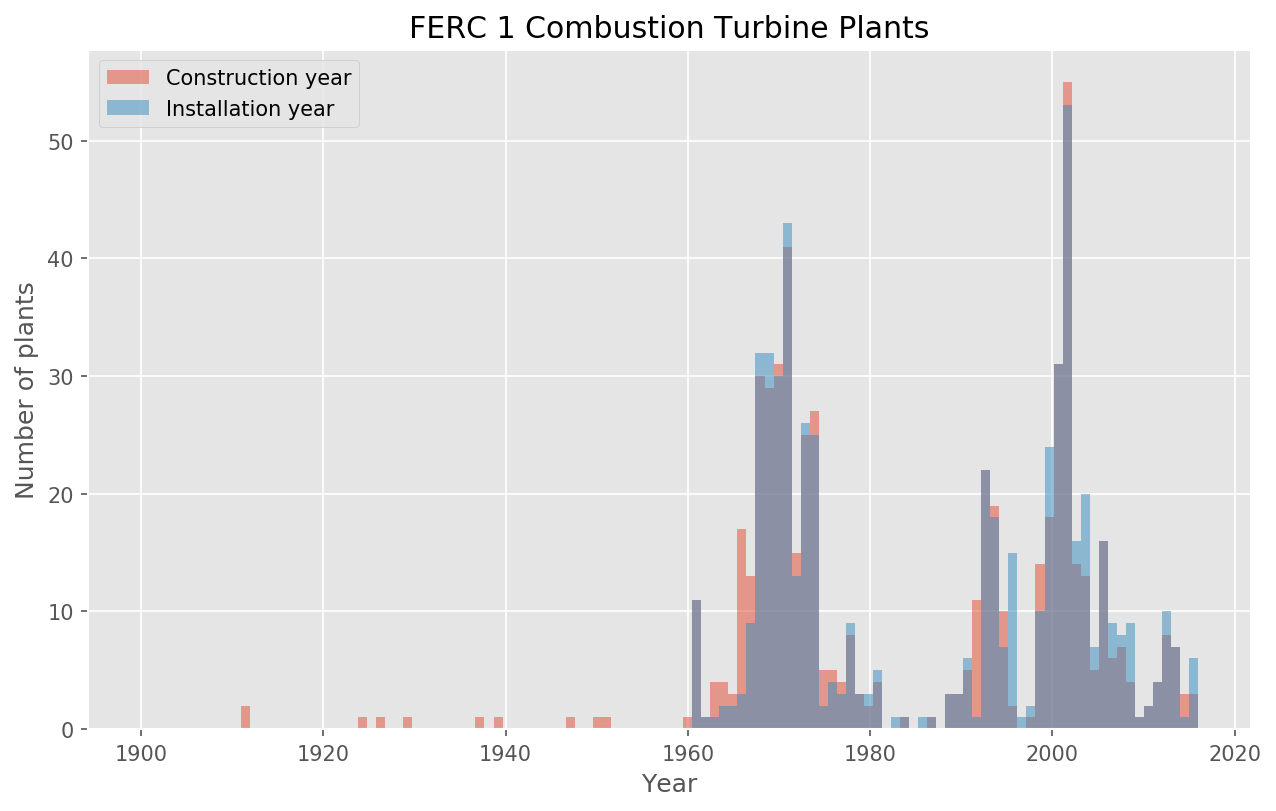

In [20]:
fig = plt.figure()
# ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
#                    xticklabels=[], ylim=(-1.2, 1.2))
plt.xlabel('Year')
plt.ylabel('Number of plants')
plt.title('FERC 1 Combustion Turbine Plants')

mpl.pyplot.hist(ct.construction_year, bins = 117, range = [1900,2016], alpha=0.5, label='Construction year')
mpl.pyplot.hist(ct.installation_year, bins = 117, range = [1900,2016], alpha=0.5, label='Installation year')
mpl.pyplot.legend(loc='upper left');

/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


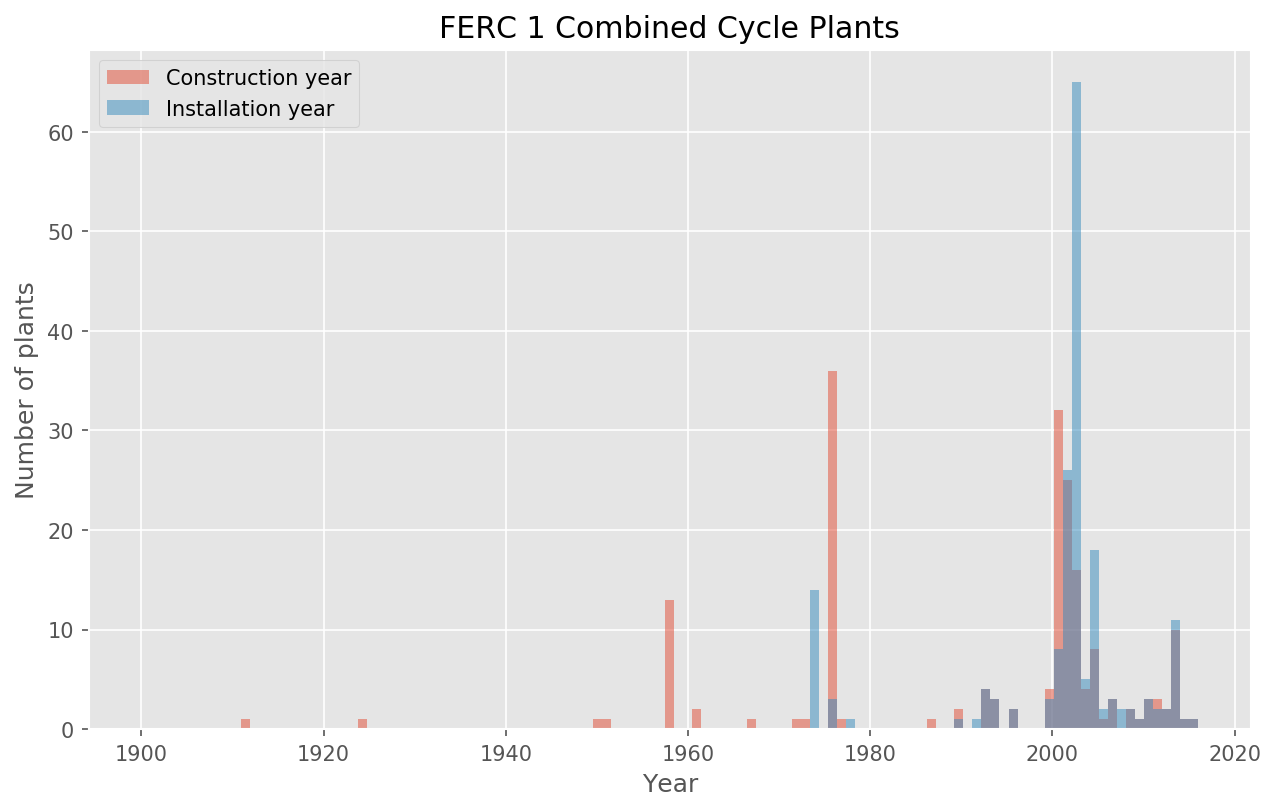

In [21]:
fig = plt.figure()
# ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
#                    xticklabels=[], ylim=(-1.2, 1.2))
plt.xlabel('Year')
plt.ylabel('Number of plants')
plt.title('FERC 1 Combined Cycle Plants')

mpl.pyplot.hist(cc.construction_year, bins = 117, range = [1900,2016], alpha=0.5, label='Construction year')
mpl.pyplot.hist(cc.installation_year, bins = 117, range = [1900,2016], alpha=0.5, label='Installation year')
mpl.pyplot.legend(loc='upper left');

/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/alana/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


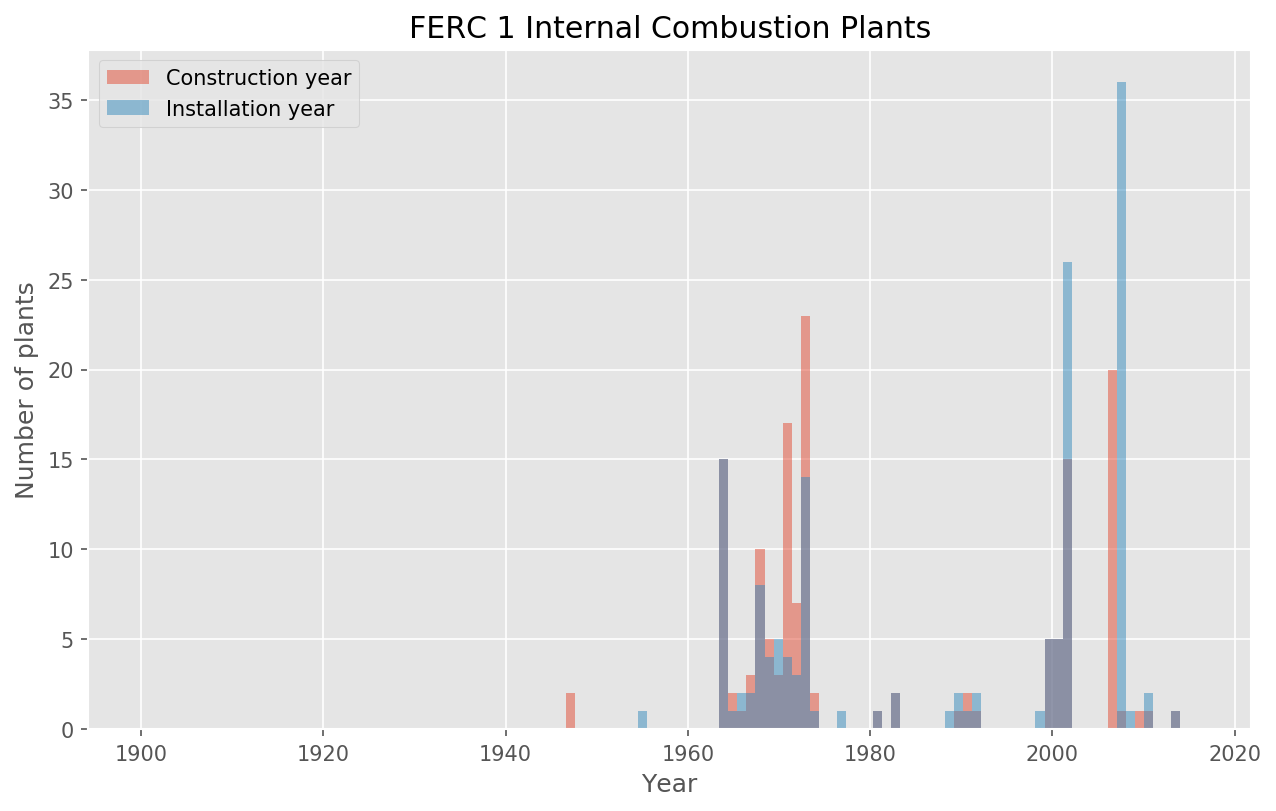

In [22]:
fig = plt.figure()
# ax1 = fig.add_axes([0.1, 0.5, 0.8, 0.4],
#                    xticklabels=[], ylim=(-1.2, 1.2))
plt.xlabel('Year')
plt.ylabel('Number of plants')
plt.title('FERC 1 Internal Combustion Plants')

mpl.pyplot.hist(ic.construction_year, bins = 117, range = [1900,2016], alpha=0.5, label='Construction year')
mpl.pyplot.hist(ic.installation_year, bins = 117, range = [1900,2016], alpha=0.5, label='Installation year')
mpl.pyplot.legend(loc='upper left');


In [23]:
# When np.isfinite or ~np.isnan are used for some of the variables, nans remain
steam = steam[pd.notnull(steam['construction_year'])]
steam = steam[pd.notnull(steam['installation_year'])]
steam = steam[pd.notnull(steam['capacity_mw'])]
steam = steam[np.isfinite(steam['heat_rate'])]

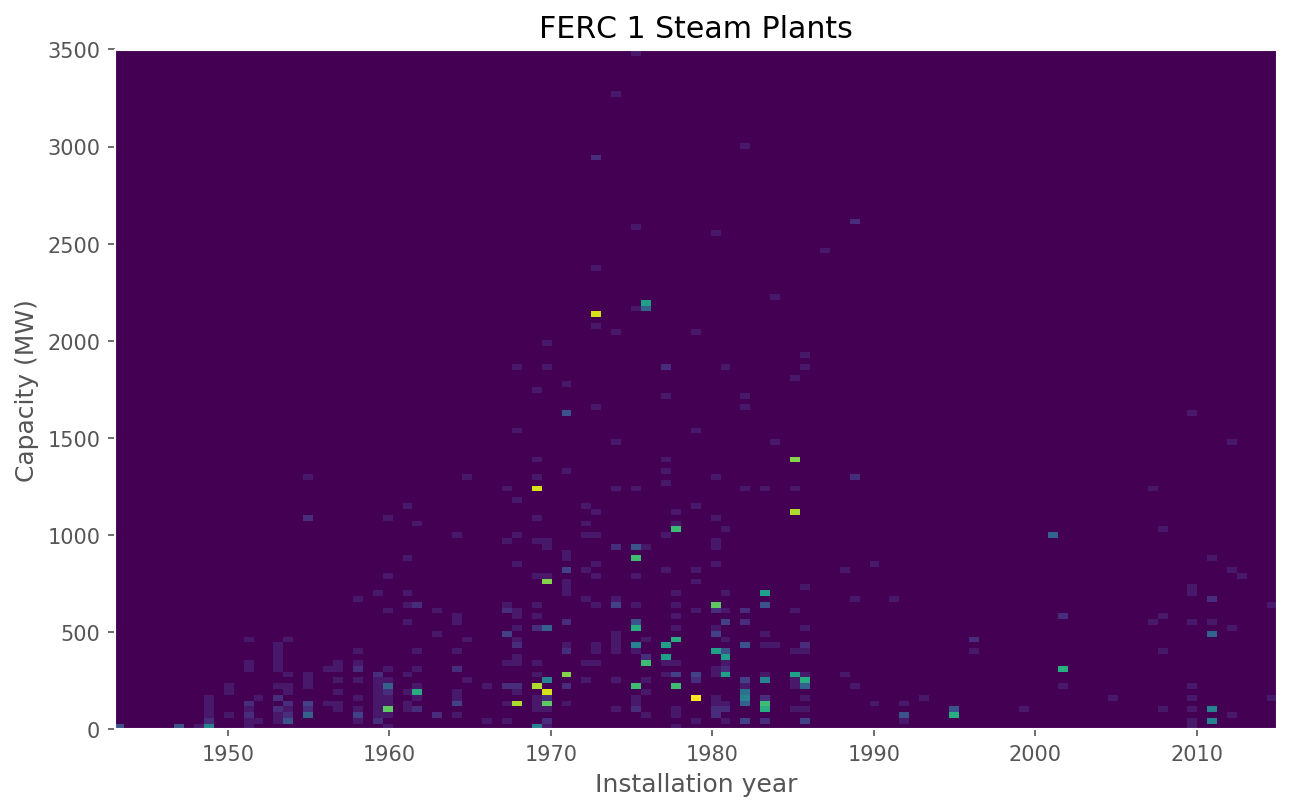

In [24]:
plt.xlabel('Installation year')
plt.ylabel('Capacity (MW)')
plt.title('FERC 1 Steam Plants')

mpl.pyplot.hist2d(steam.installation_year, steam.capacity_mw, bins=117);
#1940 and forward, up to 3K megawatts, just steam - natural groupings?
# install, constru, capacity, and HR then we should find groupings to work wtih.


In [25]:
# post 2000 spikes; uptick in construction in 1960; bigger bins in y axis, 300 or 500 MW, at least 100 MW - 
# try running regressions on all different combinations - which ones give better results?

In [26]:
def ferc1_record_subsetting(df, plant_type = 'steam', year_var = 'installation_year', 
                            old = 1970, new = 1987):
    """ Subsets records by plant type and vintage. Creates new column for vintage.
    Input variables:
        'old' = year cutoff below which plants are considered 'old'
        'new' = year cutoff above which plants are considered 'new'
        'plant_type' = FERC 1 plant types, including: 'steam', 'combustion_turbine', 'internal_combustion', 'nuclear', 'combined_cycle', 'photovoltaic'
        'year_var' = either 'installation_year' or 'construction_year'
        
        Returns data frame with new column for vintage, and subset to the specified plant types.
        """
    
    out_df = df[(df['plant_type'] == plant_type)]
    out_df.loc[out_df[year_var] <= old,'vintage'] = 'old'
    out_df.loc[out_df[year_var] >= new,'vintage'] = 'new'
    out_df.loc[(out_df[year_var] > old) & (out_df[year_var] <= new), "vintage"] = 'mid'
    
    
    return out_df

In [27]:
### Still need to convert 'vintage' to a categorical variable for further use

In [47]:
new = ferc1_record_subsetting(out_df_s)

In [48]:
# Set up variables for OLS regression 

# X = new[["net_generation", "heat_rate", "fuel_cost_btu"]]
X = new[["capacity_mw", "net_generation_mwh"]]
# X = new[["non_fuel_costs"]]
# X = new[["expns_fuel"]]

# y = new["opex_fuel"]
y = new[["non_fuel_costs"]]
# y = new[["net_generation_mwh"]]


X = sm.add_constant(X) ## add an intercept

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         non_fuel_costs   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     3189.
Date:                Thu, 10 Jan 2019   Prob (F-statistic):               0.00
Time:                        09:36:50   Log-Likelihood:                -93130.
No. Observations:                5116   AIC:                         1.863e+05
Df Residuals:                    5113   BIC:                         1.863e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.251e+06   3.83e+05      3.270      0.001    5.01e+05       2e+06
capacity_mw         1.734e+04    829.941     20.890      0.000    1.57e+04     1.9e+04
net_generation_mwh     3.3941      0.146     23.203      0.000       3.107       3.681
==============================================================================
Omnibus:                     6565.843   Durbin-Watson:                   0.444
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1902946.705
Skew:                           6.882   Prob(JB):                         0.00
Kurtosis:                      96.475   Cond. No.                     6.22e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.22e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
# Use sklearn linear_model to fit the same regression
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
# print(predictions)[0:5]
lm.score(X,y)

0.5550672221213224

In [31]:
scipy.stats.linregress(out_df.net_generation_mwh, out_df.non_fuel_costs)

LinregressResult(slope=5.7927750742455215, intercept=2779380.463638164, rvalue=0.7092394389659693, pvalue=0.0, stderr=0.056057891675070165)

In [32]:
# numpy.polyfit(ferc1_training_steam.net_generation, ferc1_training_steam.expns_fuel, 1)

In [33]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split

In [34]:
x = out_df.net_generation_mwh
y = out_df.non_fuel_costs
x_reshape = out_df.net_generation_mwh.values.reshape(-1,1)
y_reshape = out_df.non_fuel_costs.values.reshape(-1,1)

In [35]:
# intercept, slope, corr_coeff = plot_linear_regression(x_reshape, y_reshape)
# plt.show()


Text(0, 0.5, 'non-fuel costs')

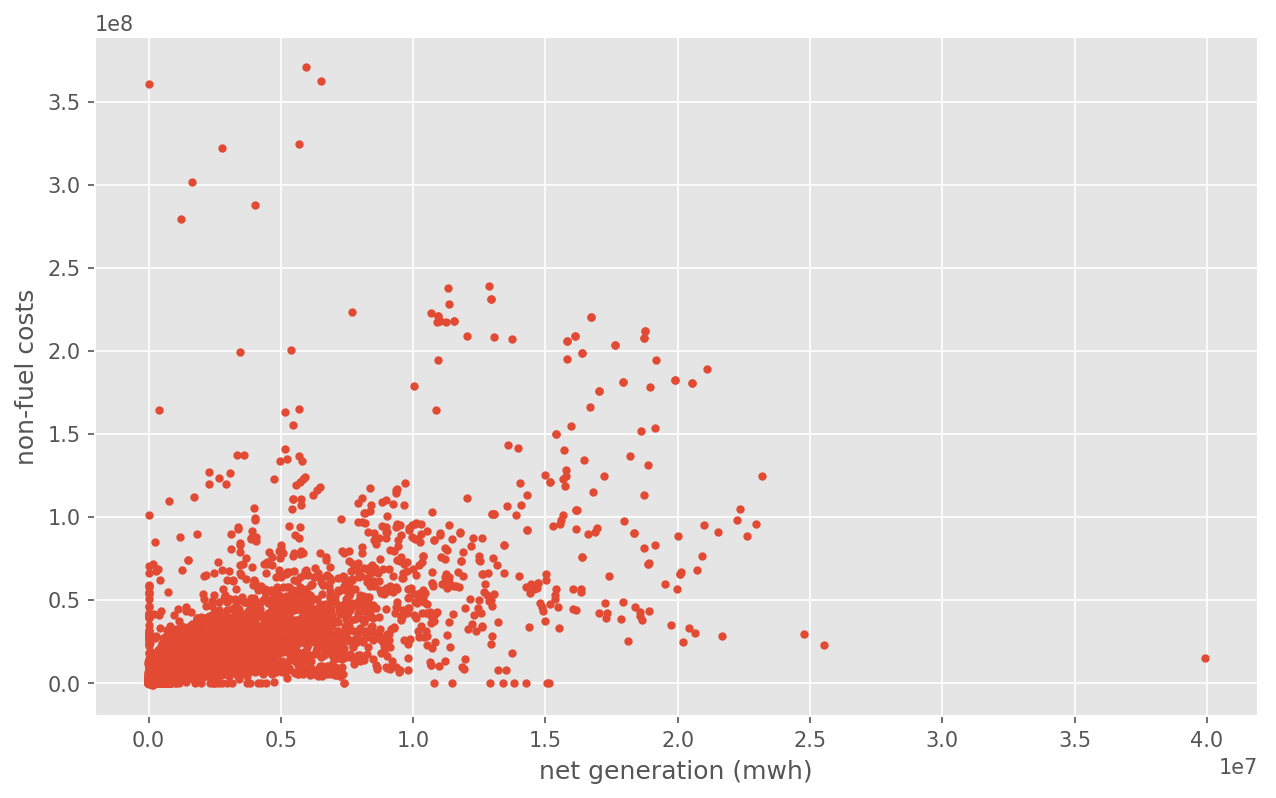

In [36]:
plt.plot(x,y,'.')

plt.xlabel('net generation (mwh)')
plt.ylabel('non-fuel costs')

In [37]:
### Exploration of other approaches...

In [38]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=0)

In [39]:
x_train= x_train.values.reshape(-1, 1)
y_train= y_train.values.reshape(-1, 1)
x_test = x_test.values.reshape(-1, 1)

In [40]:
ridge = Ridge(fit_intercept=True, alpha=0.5)

In [41]:
ridge.fit(x_reshape,y_reshape)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [42]:
sklearn.linear_model.Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)
# ferc1_training_steam.net_generation_mwh, ferc1_training_steam.non_fuel_costs)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [43]:
clf = sklearn.linear_model.Ridge(alpha=1)
clf = sklearn.linear_model.Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False, random_state=None, solver='auto', tol=0.001)

clf.fit(x_reshape, y_reshape)
# Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,normalize=False, random_state=None, solver='auto', tol=0.001)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [44]:
result = clf.fit(x_reshape, y_reshape, sample_weight=None)

In [45]:
clf.score(x_reshape,y_reshape)

0.5030205817847624

In [46]:
result.get_params()

{'alpha': 1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}